In [1]:
!pip install -q hillclimbers

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from hillclimbers import climb_hill, partial
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [5]:
def get_data(oof_path, test_oof_path):
    oof_pred_probs = pickle.load(open(oof_path, 'rb'))
    test_pred_probs = pickle.load(open(test_oof_path, 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [6]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [7]:
oof_paths = glob.glob(f'{CFG.oof_path}/oof_pred_probs/**')
test_oof_paths = glob.glob(f'{CFG.oof_path}/test_pred_probs/**')
for oof_path, test_oof_path in zip(oof_paths, test_oof_paths):
    model_name = oof_path.split('/')[-1][:-28]
    if "L1" in model_name and "PSEUDO" in model_name:
        oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(oof_path, test_oof_path)

In [8]:
hc_test_pred_probs, hc_oof_pred_probs = climb_hill(
    train=train, 
    oof_pred_df=pd.DataFrame(oof_pred_probs), 
    test_pred_df=pd.DataFrame(test_pred_probs),
    target=CFG.target,
    objective='maximize', 
    eval_metric=partial(roc_auc_score),
    negative_weights=False, 
    precision=0.001, 
    plot_hill=True, 
    plot_hist=False,
    return_oof_preds=True
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (55 total): 

LightGBM_r121_BAG_L1_PSEUDO:     0.96262 (best solo model)
LightGBM_r161_BAG_L1_PSEUDO:     0.96236
LightGBM_r15_BAG_L1_PSEUDO:      0.96225
LightGBM_r131_BAG_L1_PSEUDO:     0.96211
LightGBM_r130_BAG_L1_PSEUDO:     0.96210
XGBoost_r31_BAG_L1_PSEUDO:       0.96130
LightGBM_BAG_L1_PSEUDO:          0.96129
XGBoost_r89_BAG_L1_PSEUDO:       0.96100
XGBoost_r22_BAG_L1_PSEUDO:       0.96077
XGBoost_r95_BAG_L1_PSEUDO:       0.96060
XGBoost_r49_BAG_L1_PSEUDO:       0.96059
XGBoost_r98_BAG_L1_PSEUDO:       0.96058
LightGBMLarge_BAG_L1_PSEUDO:     0.96047
XGBoost_r34_BAG_L1_PSEUDO:       0.96011
XGBoost_BAG_L1_PSEUDO:           0.96000
LightGBM_r135_BAG_L1_PSEUDO:     0.95988
LightGBM_r143_BAG_L1_PSEUDO:     0.95984
CatBoost_r180_BAG_L1_PSEUDO:     0.95971
XGBoost_r194_BAG_L1_PSEUDO:      0.95968
CatBoost_r70_BAG_L1_PSEUDO:      0.95963
XGBoost_r33_BAG_L1_PSEUDO:       0.95941
CatBoost_r9_BAG_L1_PSEUDO:       

In [9]:
hc_score = roc_auc_score(y, hc_oof_pred_probs)
scores['Hill Climbing'] = [hc_score] * CFG.n_folds

In [10]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = hc_test_pred_probs
sub.to_csv(f'sub_hill-climbing_{hc_score:.6f}.csv', index=False)
sub.head()

,id,loan_status
0,58645,0.992484
1,58646,0.023203
2,58647,0.611098
3,58648,0.010897
4,58649,0.058804


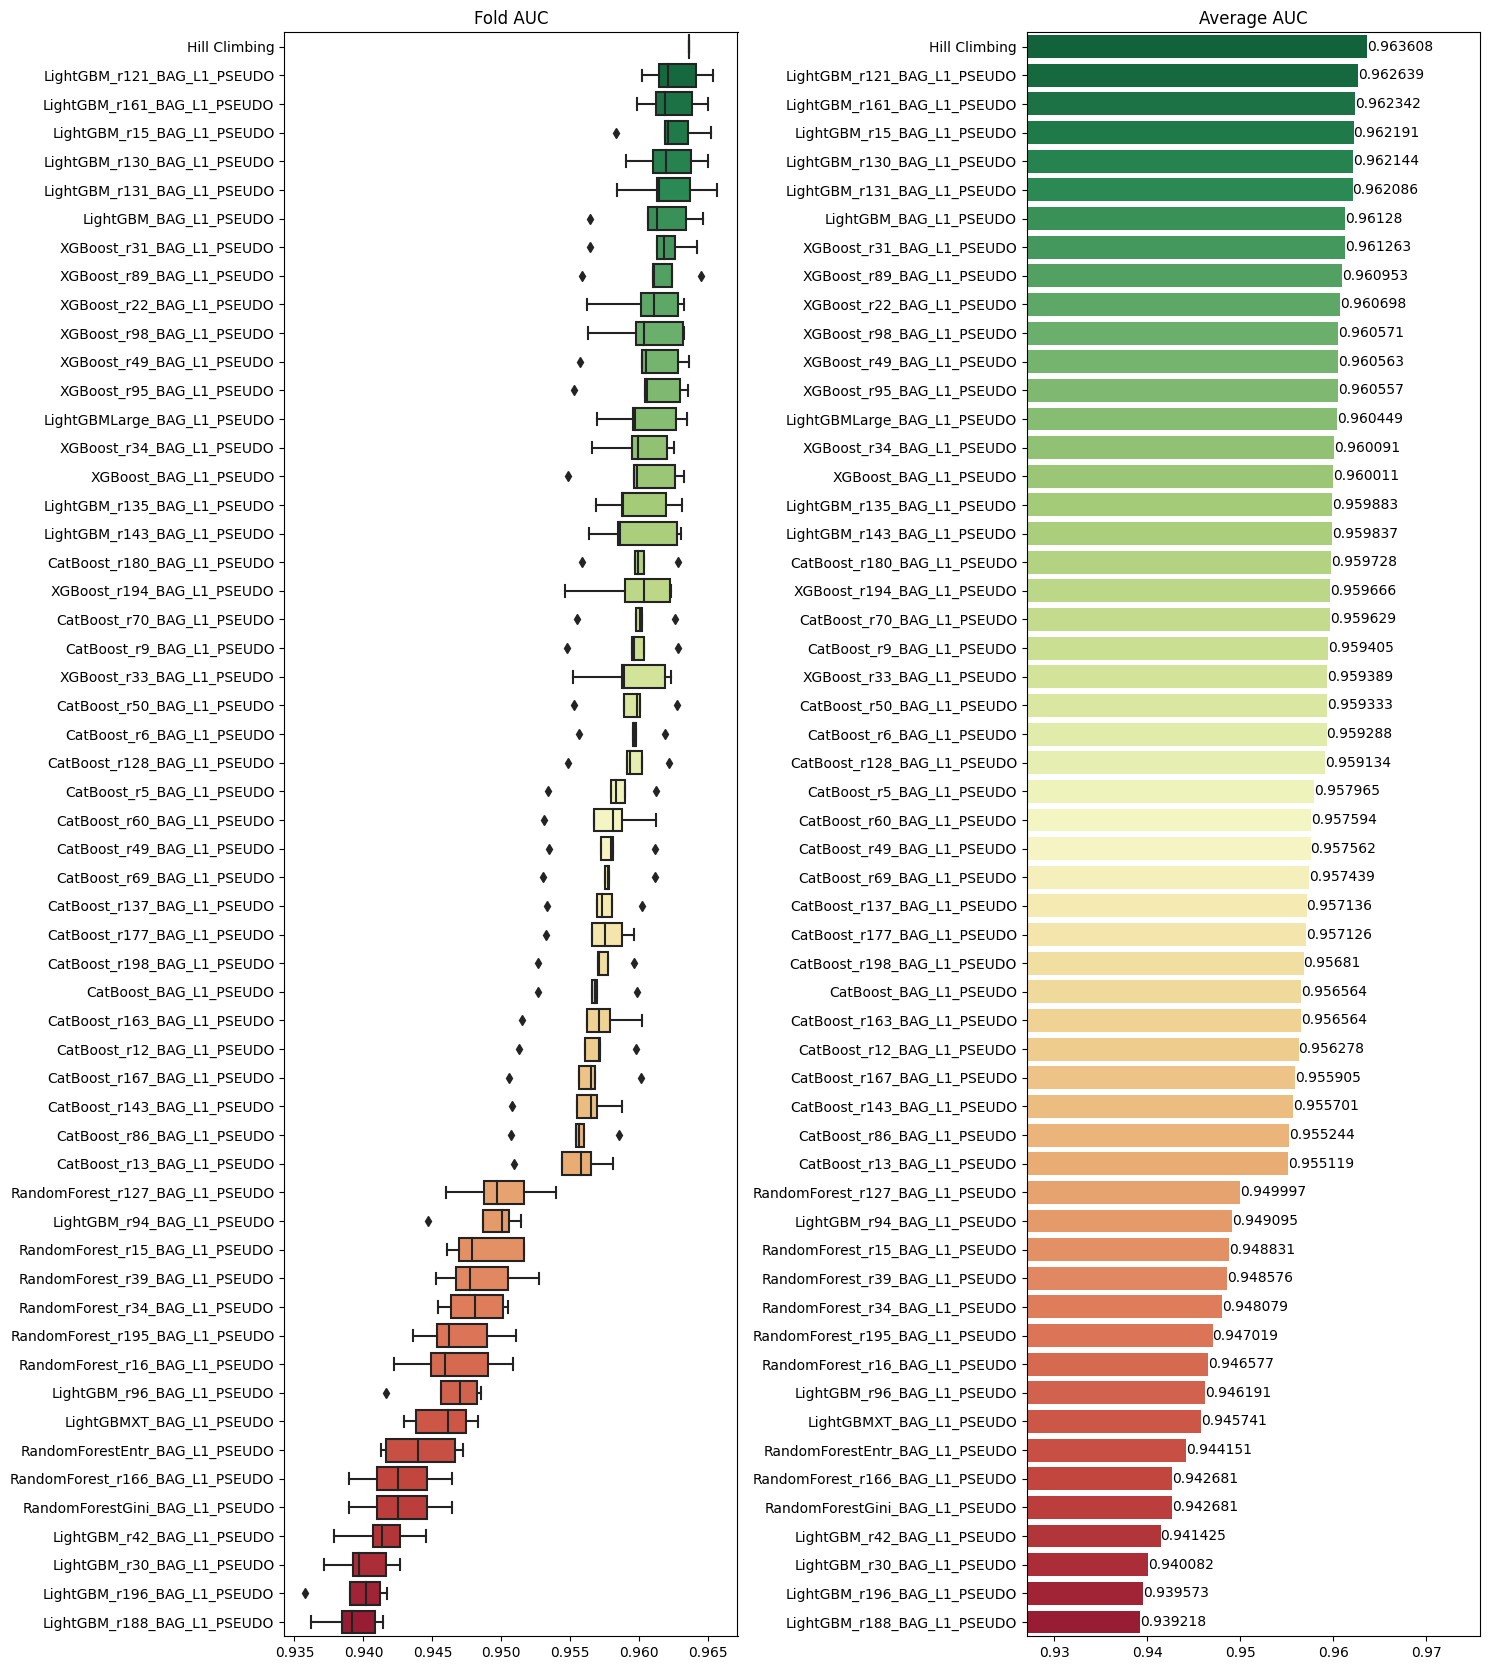

In [11]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()